In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.spatial.transform import Rotation

import astropy.coordinates
from astropy.time import Time
import astropy.units as units

import pathlib
import pickle

In [2]:
data_dir = pathlib.Path('space_packets')

def unpickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def open_apid(apid):
    files = (data_dir / f'APID_{apid}').glob('*')
    return sorted([p for f in files for p in unpickle(f)], key = lambda p: p[1])

def get_times(packets):
    return np.array([p[1] for p in packets]) * 1e5 * np.timedelta64(1, 'ns') + np.datetime64('2015-12-31T16:00')

In [3]:
adcs = open_apid(1281)[:-7] # we discard the last packets, since they have an incorrect date in the future
adcs = [a for a in adcs if len(a[0]) == 64] # filter invalid lengths
t_adcs = get_times(adcs)
tsel = t_adcs >= np.datetime64('2021-02-10T00:00:00')
t_adcs = t_adcs[tsel]
quaternion = np.array([np.frombuffer(p[0][36+6:44+6], dtype = 'int16').byteswap() for p in adcs]) * 1e-4
quaternion = quaternion[tsel]
# filter out quaternions with weird norm
filt = np.abs(np.sum(quaternion**2, axis = 1) - 1) < 1e-3
quaternion = quaternion[filt]
t_adcs = t_adcs[filt]

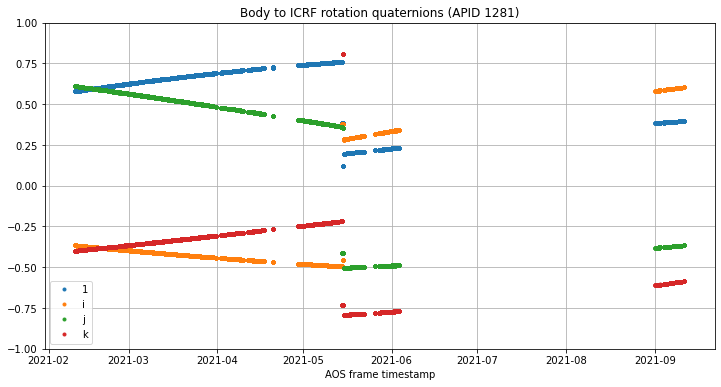

In [4]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t_adcs, quaternion, '.')
plt.ylim((-1,1))
plt.xlabel('AOS frame timestamp')
plt.title('Body to ICRF rotation quaternions (APID 1281)')
plt.legend(['1', 'i', 'j', 'k'])
plt.grid();

In [5]:
q_body_icrf = Rotation.from_quat(quaternion[:,[1,2,3,0]]) # scalar last format

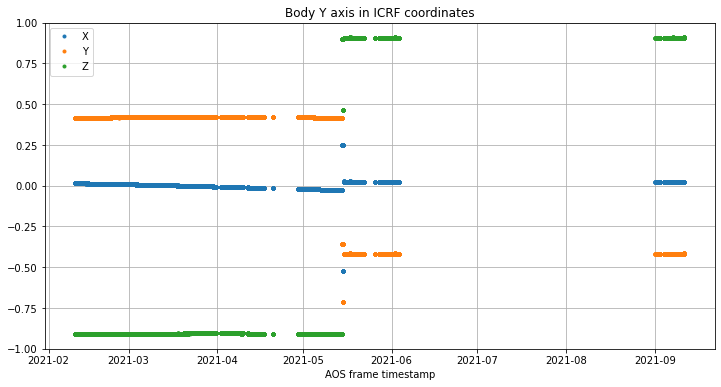

In [6]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.plot(t_adcs, q_body_icrf.apply([0,1,0]), '.')
plt.ylim((-1,1))
plt.xlabel('AOS frame timestamp')
plt.title('Body Y axis in ICRF coordinates')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

In [7]:
t_adcs_astro = Time(t_adcs)
spacecraft_earth = -astropy.coordinates.get_body('mars', t_adcs_astro).cartesian.get_xyz().to(units.km).value
spacecraft_sun = (astropy.coordinates.get_sun(t_adcs_astro).cartesian.get_xyz().to(units.km).value
 + spacecraft_earth)

In [8]:
earth_icrf = spacecraft_earth.T / np.sqrt(np.sum(spacecraft_earth**2, axis=0)).reshape((-1,1))
sun_icrf = spacecraft_sun.T / np.sqrt(np.sum(spacecraft_sun**2, axis=0)).reshape((-1,1))

In [9]:
sun_body = q_body_icrf.apply(sun_icrf, inverse = True)
earth_body = q_body_icrf.apply(earth_icrf, inverse = True)

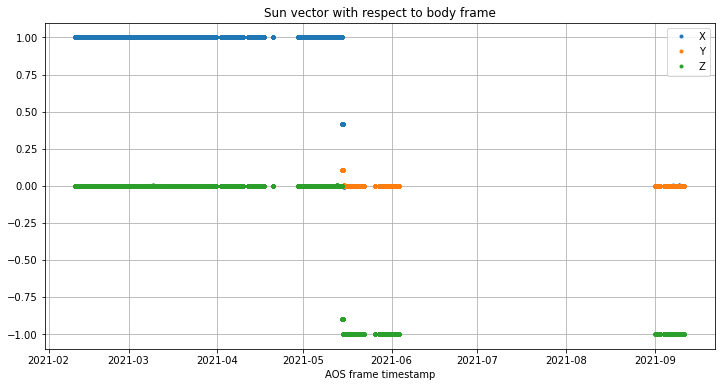

In [10]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, sun_body, '.');
plt.xlabel('AOS frame timestamp')
plt.title('Sun vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

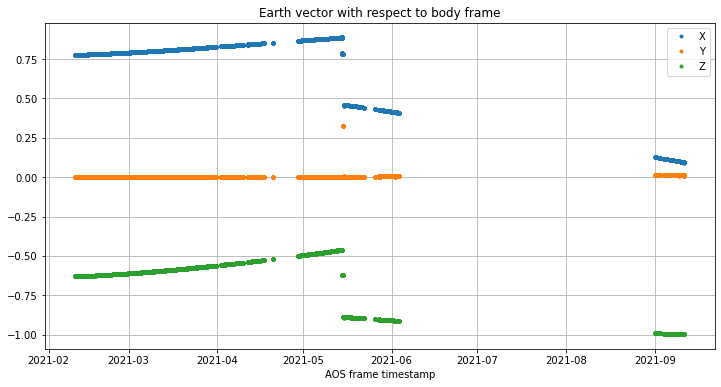

In [11]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, earth_body, '.');
plt.xlabel('AOS frame timestamp')
plt.title('Earth vector with respect to body frame')
plt.legend(['X', 'Y', 'Z'])
plt.grid();

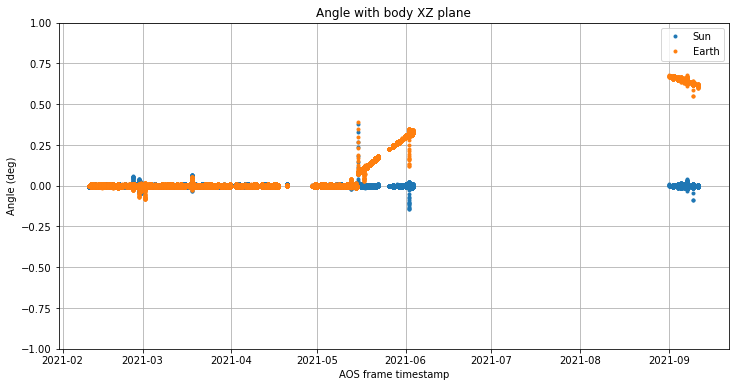

In [12]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arcsin(sun_body[:,1])), '.')
plt.plot(t_adcs, np.rad2deg(np.arcsin(earth_body[:,1])), '.')
plt.ylim((-1, 1))
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle with body XZ plane')
plt.legend(['Sun', 'Earth'])
plt.grid();

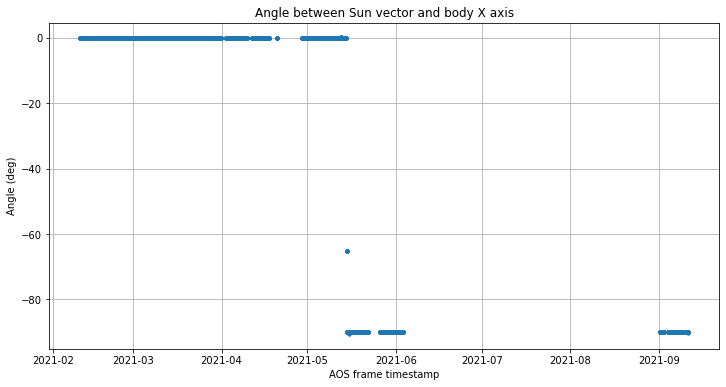

In [13]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arctan2(sun_body[:, 2], sun_body[:, 0])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Sun vector and body X axis')
plt.grid();

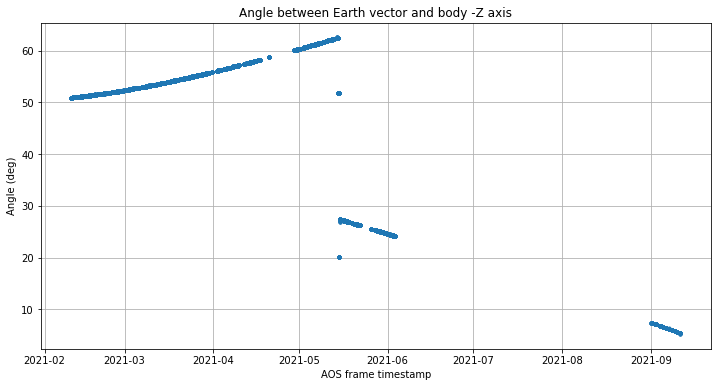

In [14]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs, np.rad2deg(np.arctan2(earth_body[:, 0], -earth_body[:, 2])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Earth vector and body -Z axis')
plt.grid();

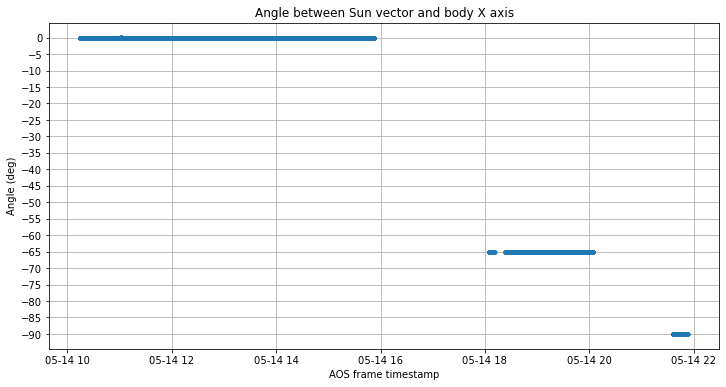

In [15]:
attitude_change = (t_adcs > np.datetime64('2021-05-14')) & (t_adcs < np.datetime64('2021-05-15'))
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(t_adcs[attitude_change],
         np.rad2deg(np.arctan2(sun_body[attitude_change, 2], sun_body[attitude_change, 0])), '.');
plt.xlabel('AOS frame timestamp')
plt.ylabel('Angle (deg)')
plt.title('Angle between Sun vector and body X axis')
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.grid();